In [5]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import MaxPooling2D 
from keras.layers import Flatten
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.utils import to_categorical 


import os,cv2
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split
from glob import glob

physical_devices = tf.config.experimental.list_physical_devices('XLA_GPU')
print("DEVICES:", physical_devices)

2.3.1
DEVICES: [PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [9]:
train_path = "../Data/TrainData/"
test_path = "../Data/TestData/"
img_dims = (64, 64)
batch_size = 64
epochs = 15

train_datagen = ImageDataGenerator(
                                   width_shift_range = 0.10,
                                   height_shift_range = 0.10,
                                   shear_range = 0.3,
                                   channel_shift_range = 0.2,
                                   rescale=1./255,
                                   validation_split=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                                                         directory = train_path,
                                                         target_size = img_dims,
                                                         batch_size = 64,
                                                         class_mode = 'categorical',
                                                         subset = 'training'
                                                        )

validation_data_generator = train_datagen.flow_from_directory( 
                                                                   directory = train_path,
                                                                   target_size = img_dims,
                                                                   batch_size = 64,
                                                                   class_mode = 'categorical',
                                                                   subset = 'validation'
                                                                  )
test_data_generator = test_datagen.flow_from_directory(
                                                          directory = test_path,
                                                          target_size = img_dims,
                                                          batch_size = 64,
                                                          class_mode = 'categorical',
                                                          shuffle = False
                                                      )

Found 3466 images belonging to 2 classes.
Found 866 images belonging to 2 classes.
Found 748 images belonging to 2 classes.


In [7]:
with tf.device('/GPU:0'):
    model = Sequential()
    mod
    
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='sigmoid'))

    print(model.summary())
    
    adam_opt = keras.optimizers.adam(lr = 0.0001)
    model.compile(optimizer = adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 256)       7168      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)       

In [10]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5)
checkpointer = ModelCheckpoint('../Models/mask_checkpoint.hd5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)


['Mask', 'Non'][0]
history = model.fit_generator(
                               train_data_generator,
                               steps_per_epoch = train_data_generator.samples/batch_size,
                               epochs = epochs,
                               callbacks = [lr_reducer, checkpointer, early_stopper],
                               validation_data = validation_data_generator,
                               validation_steps = validation_data_generator.samples/batch_size,
                               shuffle = True
                             )

Epoch 1/15
55/54 [==============================] - 9s 159ms/step - loss: 0.4849 - accuracy: 0.7776 - val_loss: 0.5853 - val_accuracy: 0.6640

Epoch 00001: val_loss improved from inf to 0.58530, saving model to ../Models/mask_checkpoint.hd5
Epoch 2/15
55/54 [==============================] - 7s 121ms/step - loss: 0.3450 - accuracy: 0.8725 - val_loss: 0.4814 - val_accuracy: 0.7552

Epoch 00002: val_loss improved from 0.58530 to 0.48141, saving model to ../Models/mask_checkpoint.hd5
Epoch 3/15
55/54 [==============================] - 8s 146ms/step - loss: 0.2717 - accuracy: 0.9008 - val_loss: 0.3622 - val_accuracy: 0.8372

Epoch 00003: val_loss improved from 0.48141 to 0.36220, saving model to ../Models/mask_checkpoint.hd5
Epoch 4/15
55/54 [==============================] - 8s 145ms/step - loss: 0.2357 - accuracy: 0.9183 - val_loss: 0.3293 - val_accuracy: 0.7979

Epoch 00004: val_loss improved from 0.36220 to 0.32925, saving model to ../Models/mask_checkpoint.hd5
Epoch 5/15
55/54 [======

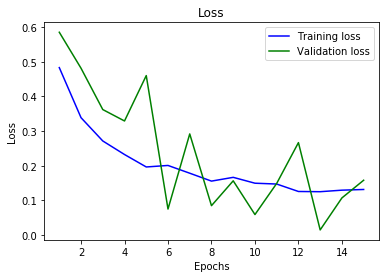

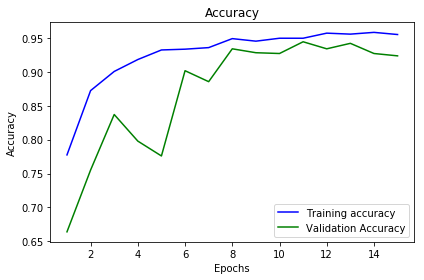

In [12]:
from matplotlib import pyplot as plt
def plot_history(history):
    loss_values = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_values = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_values = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_values = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
  
    if len(loss_values) == 0:
        print("Incomplete Data")
        return
  
    no_epochs = range(1, len(history.history[loss_values[0]]) + 1)
    plt.figure(1)
    for l in loss_values:
        plt.plot(no_epochs, history.history[l], 'b', label = 'Training loss')
    for l in val_loss_values:
        plt.plot(no_epochs, history.history[l], 'g', label = 'Validation loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
  
    plt.figure(2)  
    for l in acc_values:
        plt.plot(no_epochs, history.history[l], 'b', label = 'Training accuracy')
    for l in val_acc_values:
        plt.plot(no_epochs, history.history[l], 'g', label = 'Validation Accuracy')
    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
  
plot_history(history)

Accuracy = 97.06


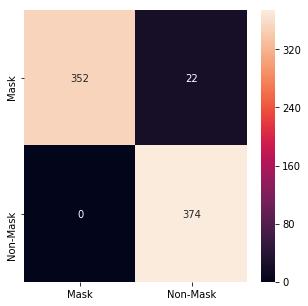

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import numpy as np
test_data_generator.reset()

actual_class_indices = test_data_generator.classes
preds = model.predict_generator(test_data_generator)
predicted_class_indices = np.argmax(preds, axis=1)

right_predictions = 0

for actual, predicted in zip(actual_class_indices, predicted_class_indices):
    if actual == predicted: 
        right_predictions += 1

print("Accuracy =", round(right_predictions/len(actual_class_indices)*100, 2))

cm = confusion_matrix(actual_class_indices, predicted_class_indices)
df_cm = pd.DataFrame(cm, index = ["Mask", "Non-Mask"], columns = ["Mask", "Non-Mask"])
plt.figure(figsize = (5, 5))
sn.heatmap(df_cm, annot=True,fmt='g');

In [17]:
from tensorflow.keras.models import Sequential, save_model
filepath = '../Models/mask_model_final.h5'
save_model(model, filepath, save_format='h5')